Test ability to create random refractive index fluctuations that have a desired correlation vs distance

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.signal import correlate, convolve

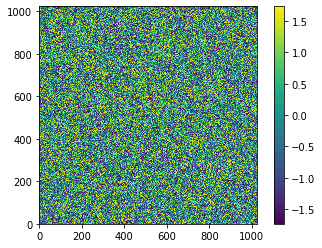

In [182]:
# Create a random Gaussian grid with mean 0 and variance 1
N_gridpts = 1024
np.random.seed(1)

random_noise = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=(N_gridpts, N_gridpts))
#random_noise = np.random.normal(size=(N_gridpts, N_gridpts))

# Plot sample of noise
plt.imshow(random_noise, origin='lower')
plt.colorbar()

In [183]:
# Calculate autocorrelation of noise
auto_corr = correlate(random_noise, random_noise, mode='same')

0.9989854080810769
(array([512]), array([512]))


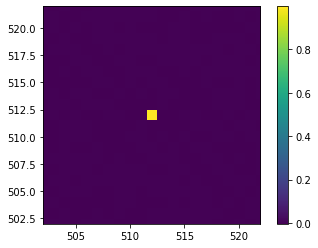

In [184]:
# Print max value divided by scaling factor - should give 1
print(np.abs(auto_corr).max() / (N_gridpts) ** 2)

# Print location of max value to zoom in on
print(np.where(auto_corr > 1e4))

plt.imshow(auto_corr / (N_gridpts) ** 2, origin='lower', interpolation='nearest')
plt.xlim([N_gridpts / 2 - 10, N_gridpts / 2 + 10])
plt.ylim([N_gridpts / 2 - 10, N_gridpts / 2 + 10])
plt.colorbar()
plt.show()

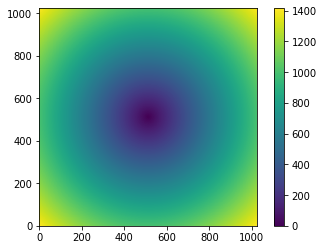

In [185]:
# Create grid in spatial frequency space
# Define number of points and amplitude
k_grid_dim = N_gridpts
k_amplitude = 1000

# Create index for kx and ky using np.newaxis
indx_kx = np.arange(k_grid_dim)[:, np.newaxis]
indx_ky = np.arange(k_grid_dim)[np.newaxis, :]

# Define difference between successive k values
dk = 2 * k_amplitude / k_grid_dim

# Create kx and ky from index, grid_dim, and dk
k_x = (indx_kx - k_grid_dim / 2) * dk
k_y = (indx_ky - k_grid_dim / 2) * dk

x = (indx_kx - k_grid_dim / 2) * np.pi / k_amplitude
y = (indx_ky - k_grid_dim / 2) * np.pi / k_amplitude

# Combine to create k_grid
k_grid = np.sqrt(k_x ** 2 + k_y ** 2)

# Plot
plt.imshow(k_grid, origin='lower')
plt.colorbar()

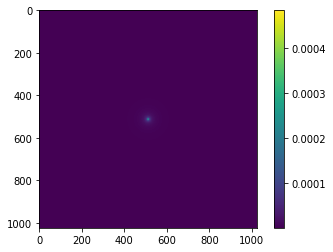

In [188]:
# Now calculate power spectral density for index of refraction on k_grid
k0 = 10
km = 1000
pow_spec_dens = 0.033 / (k0 + k_grid) ** (11 / 6) * np.exp(-k_grid ** 2 / km ** 2)
#pow_spec_dens = (np.abs(k_x) < 30) * (np.abs(k_y) < 30)

#plt.loglog(k_x.T[0, int(N_gridpts/2)+1:], pow_spec_dens[int(N_gridpts/2), int(N_gridpts/2)+1:])
#plt.xlabel("k (m^-1)")
#plt.ylabel("phi_n(k) / Cn2")

plt.imshow(pow_spec_dens)
plt.colorbar()

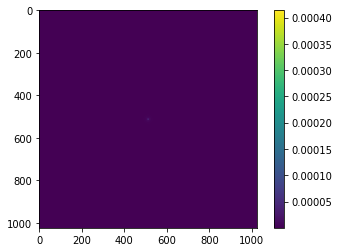

In [187]:
# Convert noise to fourier space
#fourier_noise = fft.fft2((-1) ** (indx_kx + indx_ky) * random_noise)

# Create filtered noise using power spectral density of index of refraction fluctuations
# Multiply pow_spec_dens by Cn2 = 1e-13 first though

#filtered = np.sqrt(pow_spec_dens) * fourier_noise

space_kernel = (-1) ** (indx_kx + indx_ky) * fft.ifft2((-1) ** (indx_kx + indx_ky) * np.sqrt(pow_spec_dens))

plt.imshow(space_kernel.real)
plt.colorbar()

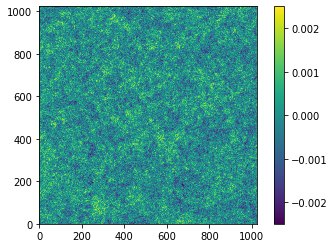

In [189]:
# Plot filtered

filtered = convolve(space_kernel, random_noise, mode='same')

plt.imshow(filtered.real, origin='lower')
plt.colorbar()

In [190]:
from collections import defaultdict

R = np.sqrt(x ** 2 + y ** 2).reshape(-1)
n0 = pos_space.real[pos_space.shape[0]//2, pos_space.shape[1]//2] 

stat = defaultdict(list)

for r, n in zip(R, pos_space.reshape(-1).real):
    stat[r].append((n - n0) ** 2)
    
print(max(len(_) for _ in stat.values()))    

stat = {r: np.mean(val) for r, val in stat.items()}

96


In [191]:
def get_seeds(size):
    """
    Generate unique random seeds for subsequently seeding them into random number generators in multiprocessing simulations
    This utility is to avoid the following artifact:
        https://stackoverflow.com/questions/24345637/why-doesnt-numpy-random-and-multiprocessing-play-nice
    :param size: number of samples to generate
    :return: numpy.array of np.uint32
    """
    # Note that np.random.seed accepts 32 bit unsigned integers

    # get the maximum value of np.uint32 can take
    max_val = np.iinfo(np.uint32).max

    # A set of unique and random np.uint32
    seeds = set()

    # generate random numbers until we have sufficiently many nonrepeating numbers
    while len(seeds) < size:
        seeds.update(
            np.random.randint(max_val, size=size, dtype=np.uint32)
        )

    # make sure we do not return more numbers that we are asked for
    return np.fromiter(seeds, np.uint32, size)

In [192]:
def get_realization_n_minus_n0(seed):
    
    np.random.seed(seed)
    random_noise = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=(N_gridpts, N_gridpts))
    pos_space = convolve(space_kernel, random_noise, mode='same')
    return pos_space.real * pos_space.real[N_gridpts//2, N_gridpts//2]

In [193]:
from multiprocessing import Pool

with Pool() as pool:
        realizations = list(pool.imap(get_realization_n_minus_n0, get_seeds(1000)))

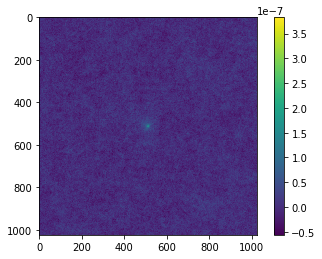

In [194]:
plt.imshow(np.mean(realizations, axis=0))
plt.colorbar()

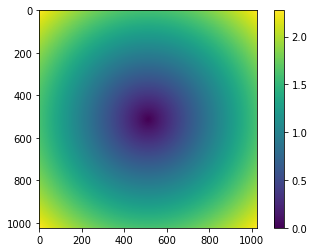

In [42]:
r = np.sqrt(x ** 2 + y ** 2)
plt.imshow(r)
plt.colorbar()

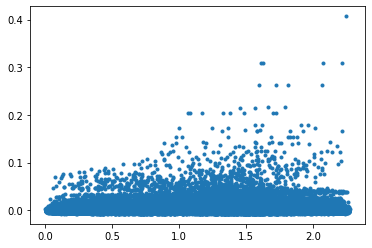

In [44]:
r = np.sqrt(x ** 2 + y ** 2).reshape(-1)
indx = np.argsort(r)

r = r[indx]
auto_corr = auto_corr.reshape(-1)[indx]

plt.plot(r, auto_corr.real, '.')